In [1]:
import pandas as pd
import numpy as np

# Generate customer data
customer_data = {
    'Customer_ID': range(1, 51),
    'Name': ['Customer_' + str(i) for i in range(1, 51)],
    'City': ['City_' + str(np.random.randint(1, 11)) for _ in range(50)]
}
customers_df = pd.DataFrame(customer_data)

# Generate order data
order_data = {
    'Customer_ID': np.random.choice(range(1, 51), size=500),
    'Product_Name': np.random.choice(['Product_A', 'Product_B', 'Product_C', 'Product_D', 'Product_E'], size=500),
    'Order_Quantity': np.random.randint(1, 11, size=500),
    'Price_Per_Item': np.random.randint(10, 101, size=500),  # Assuming price range from 10 to 100
}

# Calculate total price for each order
order_data['Total_Price'] = order_data['Order_Quantity'] * order_data['Price_Per_Item']

orders_df = pd.DataFrame(order_data)

# Save dataframes to CSV files
customers_df.to_csv('customer_info.csv', index=False)
orders_df.to_csv('order_details.csv', index=False)


In [2]:
import sys
sys.executable

'C:\\Python\\Python39\\python.exe'

In [3]:
import sysconfig
print(sysconfig.get_path('include'))

C:\Python\Python39\Include


In [4]:
import os
os.environ['CURL_CA_BUNDLE'] = ""

In [5]:
import requests
requests.__version__

'2.31.0'

In [6]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [7]:
from accelerate import Accelerator
from transformers import AutoTokenizer
import transformers
import torch
import ast

In [8]:
import logging
import sys

from llama_index.callbacks import CallbackManager, LlamaDebugHandler
from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import messages_to_prompt, completion_to_prompt
from llama_index.embeddings import HuggingFaceEmbedding

import os
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index import StorageContext, load_index_from_storage

from llama_index.node_parser import SimpleNodeParser
from llama_index import VectorStoreIndex, set_global_service_context
from llama_index.evaluation import DatasetGenerator, RelevancyEvaluator

from IPython.display import Markdown, display
from llama_index.prompts import PromptTemplate

from accelerate import Accelerator

import os
import re
import glob
import fitz


In [9]:
import logging
import sys
from IPython.display import Markdown, display

import pandas as pd
from llama_index.query_engine import PandasQueryEngine


In [10]:
import langchain
langchain.__version__

'0.0.330'

In [11]:
import chromadb
chromadb.__version__

'0.4.15'

In [12]:
import pydantic
pydantic.__version__

'1.10.13'

In [13]:
n_gpu_layers = 100   # Metal set to 1 is enough.
n_batch = 1024  # Should be between 1 and n_ctx, consider the amount of RAM of your Apple Silicon Chip.


logging.basicConfig(stream=sys.stdout, level=logging.INFO)  # Change INFO to DEBUG if you want more extensive logging
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

llama_debug = LlamaDebugHandler(print_trace_on_end=True)
callback_manager = CallbackManager([llama_debug])

# Make sure the model path is correct for your system!

llm = LlamaCPP(
    model_path=r"codellama-7b-instruct.Q8_0.gguf",    
    temperature=0.1,
    max_new_tokens=1024,
    
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=5000,  # note, this sets n_ctx in the model_kwargs below, so you don't need to pass it there.
    
    # kwargs to pass to __call__()
    generate_kwargs={},
    
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU
    model_kwargs={"n_gpu_layers": n_gpu_layers, "repetition_penalty":1.5},
    
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
#     verbose=False,
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


In [14]:
accelerator = Accelerator()
llm = accelerator.prepare(llm)

In [15]:
# chunk_size - It defines the size of the chunks (or nodes) that documents are broken into when they are indexed by LlamaIndex

embeddings = HuggingFaceEmbedding()
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024,
                                               embed_model=embeddings,
                                               callback_manager=callback_manager)
set_global_service_context(service_context)


In [16]:
orders_df.head()

,Customer_ID,Product_Name,Order_Quantity,Price_Per_Item,Total_Price
0,43,Product_D,3,87,261
1,6,Product_E,10,67,670
2,18,Product_C,4,59,236
3,14,Product_A,7,22,154
4,27,Product_A,7,13,91


In [17]:
query_engine = PandasQueryEngine(df=orders_df, verbose=False)

In [18]:
%%time
response = query_engine.query(
    "Which product is the costliest?",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  2.725518 seconds
**********
  df['Total_Price'].max()
------------------------------
1000
Wall time: 2.73 s


In [19]:
print(response.metadata["pandas_instruction_str"])

  df['Total_Price'].max()


Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.757519 seconds
**********
  df['Product_Name'].value_counts().plot(kind='pie', autopct='%1.1f%%')
------------------------------
AxesSubplot(0.260833,0.125;0.503333x0.755)
Wall time: 2.32 s


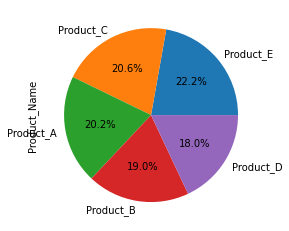

In [20]:
%%time
response = query_engine.query(
    "Plot a pie chart of number of quantities of each product",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.490018 seconds
**********
  df['Product_Name'].value_counts().plot(kind='bar')
------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 1.51 s


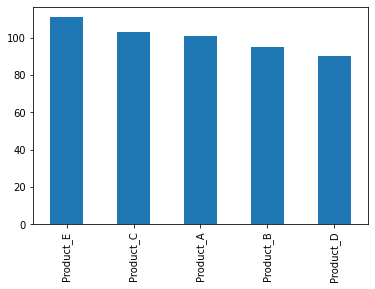

In [21]:
%%time
response = query_engine.query(
    "Create a plot showing total order quantites of each product type",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  3.444934 seconds
**********
  df.groupby(['Customer_ID', 'Product_Name'])['Order_Quantity'].sum().unstack(fill_value=0).plot(kind='bar', stacked=True, rot=0)
------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
Wall time: 3.53 s


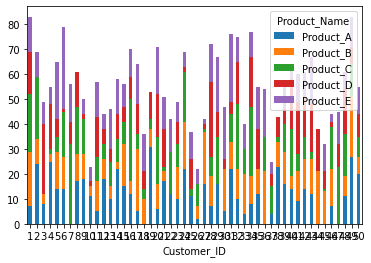

In [22]:
%%time
response = query_engine.query(
    "For each customer I want a plot showing distibution how many quantity of each product_type they bought\
    customer_ID should be on X axis and y axis should be totat order_quantity of each product type\
    Make a vertical stacked column chart",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

In [23]:
orders_df[(orders_df['Customer_ID']==1) & (orders_df['Product_Name']=='Product_A')]

,Customer_ID,Product_Name,Order_Quantity,Price_Per_Item,Total_Price
212,1,Product_A,7,41,287


In [24]:
%%time
response = query_engine.query(
    "    GIve me total quantity of each product sold, summarize results by product type",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.46754 seconds
**********
  df.groupby('Product_Name')['Order_Quantity'].sum()
------------------------------
Product_Name
Product_A    593
Product_B    520
Product_C    567
Product_D    503
Product_E    572
Name: Order_Quantity, dtype: int32
Wall time: 1.47 s


In [25]:
%%time
response = query_engine.query(
    "    GIve me total quantity and total value of each product sold in a new table.",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.923351 seconds
**********
  df.groupby('Product_Name')['Order_Quantity', 'Total_Price'].sum().reset_index()
------------------------------
  Product_Name  Order_Quantity  Total_Price
0    Product_A             593        33498
1    Product_B             520        29260
2    Product_C             567        31607
3    Product_D             503        25567
4    Product_E             572        28733
Wall time: 1.93 s


In [26]:
orders_df.head()

,Customer_ID,Product_Name,Order_Quantity,Price_Per_Item,Total_Price
0,43,Product_D,3,87,261
1,6,Product_E,10,67,670
2,18,Product_C,4,59,236
3,14,Product_A,7,22,154
4,27,Product_A,7,13,91


In [27]:
%%time
response = query_engine.query(
    "GIve me total quantity and total value of each product sold in a new\
    table. Use these values to calculate avg_price per item overall",
)

print(response.metadata["pandas_instruction_str"])
print('------------------------------')
print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.9644 seconds
**********
  df.groupby('Product_Name')['Order_Quantity', 'Total_Price'].sum().reset_index()
------------------------------
  Product_Name  Order_Quantity  Total_Price
0    Product_A             593        33498
1    Product_B             520        29260
2    Product_C             567        31607
3    Product_D             503        25567
4    Product_E             572        28733
Wall time: 1.97 s


In [ ]:
orders_df.head()

In [ ]:
customers_df.head()

In [29]:
instruction_str = (
    "1.PRINT ONLY THE EXPRESSION.\n\
    2. Do not quote the expression.\n"
)

In [30]:
basic_info = "I have two pandas df and details are below.\
Generate python code for the query asked and give only query as the output.\
-------------------------------------------\
dataframe 1\
orders_df and it has columns\
'Customer_ID': unique ID for each customer,\
'Product_Name': Unique name or type of the product,\
'Order_Quantity': Number of items of particular product ordered,\
'Price_per_item': Price of single item,\
'Total_Price': Price_per_item*Order_quantity.\
Dataframe 2\
customers_df and it has columns\
'Customer_ID': unique ID for each customer,\
'Name': name of the customer,\
'City': City that the customer lives in and it is also the city of the order.\
--------------------------------------------\
Generate python code for the following query:\
"

In [32]:
query_engine = PandasQueryEngine(df=orders_df,instruction_str=instruction_str,\
                                 verbose=False)

In [33]:
%%time
response = query_engine.query(basic_info+
    "COmbine tables customers_df and orders_df on customer_ID and then calculate\
    the total amount of money spent by each city and order by total_price",
)


# print(response.metadata["pandas_instruction_str"])
# print('------------------------------')
# print(response)

Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  3.948302 seconds
**********
Wall time: 3.98 s


Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\llama_index\query_engine\pandas\output_parser.py", line 61, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "C:\Python\Python39\lib\site-packages\llama_index\exec_utils.py", line 140, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 1, in <module>
NameError: name 'customers_df' is not defined


In [34]:
if str(response).find('error running')==-1:
    print(response)
else:
    print('Doing a custom eval')
    eval_str = response.metadata["pandas_instruction_str"]
    eval_str = eval_str.strip("` ")
    print(eval_str)
    print(eval(eval_str))


Doing a custom eval
customers_df.merge(orders_df, on='Customer_ID').groupby('City')['Total_Price'].sum().sort_values(ascending=False)
City
City_10    27878
City_3     24888
City_6     18877
City_9     15490
City_7     13598
City_2     12887
City_5     12375
City_1     11210
City_8      6307
City_4      5155
Name: Total_Price, dtype: int32


Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  8.17496 seconds
**********
--------------------
Doing a custom eval

import pandas as pd

# Combine tables customers_df and orders_df on customer_ID
combined_df = pd.merge(customers_df, orders_df, on='Customer_ID')

# Group by city and calculate total quantity of products bought
total_quantity_by_city = combined_df.groupby('City')['Order_Quantity'].sum()

# Plot the result
total_quantity_by_city.plot(kind='bar', title='Total Quantity of Products Bought by City')

None
Wall time: 8.2 s


Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\llama_index\query_engine\pandas\output_parser.py", line 61, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "C:\Python\Python39\lib\site-packages\llama_index\exec_utils.py", line 140, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 0
    
SyntaxError: unexpected EOF while parsing


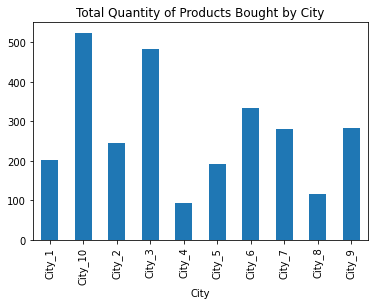

In [35]:
%%time
response = query_engine.query(basic_info+
    "Combine tables customers_df and orders_df on customer_ID and then \
    give me a plot showing total_quantoty of products bought by each city.\
    Recheck the code that you give - take time if needed.\
    Only give code blocks and no explanations.",
)

print('--------------------')

if str(response).find('error running')==-1:
    print(response)
else:
    print('Doing a custom eval')
    eval_str = response.metadata["pandas_instruction_str"]
    eval_str = eval_str.strip("` ")
    print(eval_str)
    print(exec(eval_str))


Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  8.32455 seconds
**********
--------------------
Doing a custom eval

import pandas as pd

# Combine tables customers_df and orders_df on customer_ID
combined_df = pd.merge(customers_df, orders_df, on='Customer_ID')

# Group by city and product name to get total quantity of products bought by each city
grouped_df = combined_df.groupby(['City', 'Product_Name'])['Order_Quantity'].sum()

# Plot the distribution of total quantity of products bought by each city
grouped_df.unstack().plot(kind='bar')

None
Wall time: 8.37 s


Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\llama_index\query_engine\pandas\output_parser.py", line 61, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "C:\Python\Python39\lib\site-packages\llama_index\exec_utils.py", line 140, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 0
    
SyntaxError: unexpected EOF while parsing


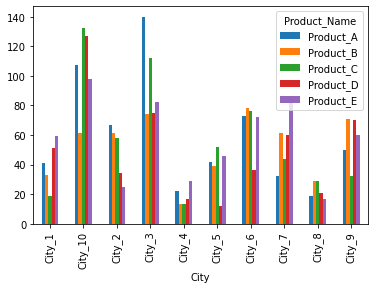

In [36]:
%%time
response = query_engine.query(basic_info+
    "Combine tables customers_df and orders_df on customer_ID and then \
    give me a plot showing total_quantoty of products bought by each city.\
    Recheck the code that you give - take time if needed.\
    If possible use Product_Name as legends in the bar plots - so that I know the distribution across different products.\
    Only give code blocks and no explanations.",
)

print('--------------------')

if str(response).find('error running')==-1:
    print(response)
else:
    print('Doing a custom eval')
    eval_str = response.metadata["pandas_instruction_str"]
    eval_str = eval_str.strip("` ")
    print(eval_str)
    print(exec(eval_str))


Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  8.554667 seconds
**********
--------------------
Doing a custom eval

import pandas as pd

# Combine tables customers_df and orders_df on customer_ID
combined_df = pd.merge(customers_df, orders_df, on='Customer_ID')

# Group by city and product name to get total quantity of products bought
grouped_df = combined_df.groupby(['City', 'Product_Name'])['Order_Quantity'].sum()

# Plot the distribution of products bought by each city
grouped_df.unstack().plot(kind='bar', stacked=True, legend=True)

None
Wall time: 8.59 s


Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\llama_index\query_engine\pandas\output_parser.py", line 61, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "C:\Python\Python39\lib\site-packages\llama_index\exec_utils.py", line 140, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 0
    
SyntaxError: unexpected EOF while parsing


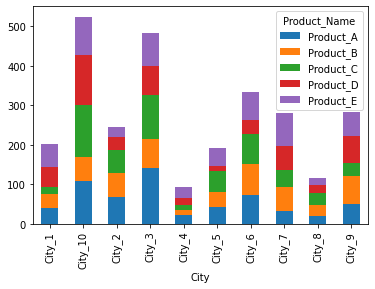

In [37]:
%%time
response = query_engine.query(basic_info+
    "Combine tables customers_df and orders_df on customer_ID and then \
    give me a plot showing total_quantoty of products bought by each city.\
    Recheck the code that you give - take time if needed.\
    If possible use Product_Name as legends in the bar plots - so that I know the distribution across different products.\
    Stack the products one over another for each city.\
    Only give code blocks and no explanations.",
)

print('--------------------')

if str(response).find('error running')==-1:
    print(response)
else:
    print('Doing a custom eval')
    eval_str = response.metadata["pandas_instruction_str"]
    eval_str = eval_str.strip("` ")
    print(eval_str)
    print(exec(eval_str))


In [38]:
%%time
response = query_engine.query(basic_info+
    "which city has most number of customers?",
)

print('--------------------')

if str(response).find('error running')==-1:
    print(response)
else:
    print('Doing a custom eval')
    eval_str = response.metadata["pandas_instruction_str"]
    eval_str = eval_str.strip("` ")
    print(eval_str)
    print(eval(eval_str))


Llama.generate: prefix-match hit


**********
Trace: query
    |_templating ->  0.0 seconds
    |_llm ->  1.312008 seconds
**********
--------------------
Doing a custom eval
customers_df['City'].value_counts().idxmax()
City_10
Wall time: 1.32 s


Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\llama_index\query_engine\pandas\output_parser.py", line 61, in default_output_processor
    output_str = str(safe_eval(module_end_str, {"np": np}, local_vars))
  File "C:\Python\Python39\lib\site-packages\llama_index\exec_utils.py", line 140, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 1, in <module>
NameError: name 'customers_df' is not defined
